## Introduction and Business Question

Implementation of seasonal flu vaccination programs play a substantial role in public health. However, in 2022, only 49% of adults are planning on obtaining a flu vaccine, despite the risks posed in forgoing it. The purpose of this project is to understand which demographics are least likely to get a flu vaccine, in order for officials to better target those demographics and utilize limited marketing resources to expanding the percentage of the population that chooses to be vaccinated. 

The models built in this project will attempt to classify whether or not an individual is likely to be vaccinated based on collected demographic data. The models will be assessed on an overall accuracy score - whether or not an individual's tendency was correctly predicted. Though the more important target in the scope of public health would be to err on the side of conservativeness - it is better to be wrong about a person not getting the vaccine than actually thinking they will get it - the business problem here is to assess what demographics should be targeted as predictors of not getting a seasonal flu vaccine. 

## Data Cleaning and Exploration

The data set used in this business is a survey of demographic information for 26,707 individuals and their decision to be vaccinated for either the H1H1 or seasonal flu vaccine. This project will focus solely on the seasonal flu vaccine. 

In [ ]:
# import packages
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt

#from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score,f1_score,confusion_matrix

from sklearn.model_selection import cross_val_score, GridSearchCV

from sklearn.ensemble import RandomForestClassifier

In [2]:
# import and examine data
df = pd.read_csv('training_set_features.csv')
df.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


In [3]:
df.shape

(26707, 36)

In [4]:
# import training labels
labels = pd.read_csv('labels.csv')
labels.head()

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,0,0,0
1,1,0,1
2,2,0,0
3,3,0,1
4,4,0,0


In [5]:
# extract target column from training labels
target = labels['seasonal_vaccine']
target.value_counts(normalize=True)

0    0.534392
1    0.465608
Name: seasonal_vaccine, dtype: float64

In [6]:
# merge dataframes for the purpose of EDA
df['seasonal_vaccine'] = labels['seasonal_vaccine']
df.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,1
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0


From looking at the distribution of the target variable, we see that the split is nearly even (considering the amount of data we have) - therefore, at this time we do not need to worry about class imbalance problems that would appear if one class of data was far more frequent than the other.

In [7]:
# examine data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 37 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

In [8]:
df['household_adults'].value_counts()

1.0    14474
0.0     8056
2.0     2803
3.0     1125
Name: household_adults, dtype: int64

In [9]:
df['household_children'].value_counts()

0.0    18672
1.0     3175
2.0     2864
3.0     1747
Name: household_children, dtype: int64

From looking at the features above, and from examining the source descriptions of the features , we can remove some of the features from the start, specifically those that are related to the H1N1 virus and not the seasonal flu. Additionally, we can remove the respondent_id feature as this will not be used for predictive reasons.

Feature documentation at this link: https://www.drivendata.org/competitions/66/flu-shot-learning/page/211/#labels

In [10]:
drop_columns = ['respondent_id','h1n1_concern','h1n1_knowledge','doctor_recc_h1n1','opinion_h1n1_vacc_effective',
                'opinion_h1n1_risk','opinion_h1n1_sick_from_vacc','hhs_geo_region','employment_industry',
                'employment_occupation']
df = df.drop(columns=drop_columns,axis=1)

In [11]:
df.isna().sum()

behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
marital_status                  1408
rent_or_own                     2042
employment_status               1463
census_msa                         0
household_adults                 249
household_children               249
seasonal_vaccine                   0
d

Now that we have identified all of the missing values in the features data frame, we need to consider how to deal with missing data. The only two continuous variables in the features are number of adults and children outside of the household that an individual is exposed to. Because the missing values in those columns are a very small percentage of the data set, we can just drop those values. For the rest of the features, which are categorical, we are better off treating the missing values as their own category, so we can replace those missing values with labels.

In [12]:
missing_household_adults = df[df['household_adults'].isnull()].index.tolist()
missing_household_children = df[df['household_children'].isnull()].index.tolist()

In [13]:
combined = list(set(missing_household_adults+missing_household_children))

In [14]:
df.drop(combined,axis=0,inplace=True)

In [15]:
df.isna().sum()

behavioral_antiviral_meds         69
behavioral_avoidance             204
behavioral_face_mask              19
behavioral_wash_hands             41
behavioral_large_gatherings       85
behavioral_outside_home           82
behavioral_touch_face            127
doctor_recc_seasonal            2097
chronic_med_condition            777
child_under_6_months             595
health_worker                    588
health_insurance               12029
opinion_seas_vacc_effective      350
opinion_seas_risk                386
opinion_seas_sick_from_vacc      394
age_group                          0
education                       1170
race                               0
sex                                0
income_poverty                  4181
marital_status                  1172
rent_or_own                     1804
employment_status               1225
census_msa                         0
household_adults                   0
household_children                 0
seasonal_vaccine                   0
d

In [16]:
df.fillna('missing',inplace=True)

In [17]:
df.isna().sum()

behavioral_antiviral_meds      0
behavioral_avoidance           0
behavioral_face_mask           0
behavioral_wash_hands          0
behavioral_large_gatherings    0
behavioral_outside_home        0
behavioral_touch_face          0
doctor_recc_seasonal           0
chronic_med_condition          0
child_under_6_months           0
health_worker                  0
health_insurance               0
opinion_seas_vacc_effective    0
opinion_seas_risk              0
opinion_seas_sick_from_vacc    0
age_group                      0
education                      0
race                           0
sex                            0
income_poverty                 0
marital_status                 0
rent_or_own                    0
employment_status              0
census_msa                     0
household_adults               0
household_children             0
seasonal_vaccine               0
dtype: int64

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26458 entries, 0 to 26706
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   behavioral_antiviral_meds    26458 non-null  object 
 1   behavioral_avoidance         26458 non-null  object 
 2   behavioral_face_mask         26458 non-null  object 
 3   behavioral_wash_hands        26458 non-null  object 
 4   behavioral_large_gatherings  26458 non-null  object 
 5   behavioral_outside_home      26458 non-null  object 
 6   behavioral_touch_face        26458 non-null  object 
 7   doctor_recc_seasonal         26458 non-null  object 
 8   chronic_med_condition        26458 non-null  object 
 9   child_under_6_months         26458 non-null  object 
 10  health_worker                26458 non-null  object 
 11  health_insurance             26458 non-null  object 
 12  opinion_seas_vacc_effective  26458 non-null  object 
 13  opinion_seas_ris

In [19]:
# split into features and target variable
y = df['seasonal_vaccine']
X = df.drop('seasonal_vaccine',axis=1)

## Model 1: Logistic Regression

The first model fitted will be a logistic regression. Logistic regression outputs the probability of a classification, which we can then round to treat as an actual classification. For this business problem, which is to maximize the number of people who receive the vaccine, we will use accuracy as the score of predictive value for the final model chosen.

In [ ]:
X_numerical = X.iloc[:,24:26]

In [ ]:
X_numerical.info()

In [ ]:
X_categorical = X.iloc[:,0:24]
X_categorical.astype(str)

In [ ]:
X_categorical.info()

In [20]:
X_new = pd.get_dummies(X)

In [21]:
X_new.head()

,household_adults,household_children,behavioral_antiviral_meds_0.0,behavioral_antiviral_meds_1.0,behavioral_antiviral_meds_missing,behavioral_avoidance_0.0,behavioral_avoidance_1.0,behavioral_avoidance_missing,behavioral_face_mask_0.0,behavioral_face_mask_1.0,...,rent_or_own_Own,rent_or_own_Rent,rent_or_own_missing,employment_status_Employed,employment_status_Not in Labor Force,employment_status_Unemployed,employment_status_missing,"census_msa_MSA, Not Principle City","census_msa_MSA, Principle City",census_msa_Non-MSA
0,0.0,0.0,1,0,0,1,0,0,1,0,...,1,0,0,0,1,0,0,0,0,1
1,0.0,0.0,1,0,0,0,1,0,1,0,...,0,1,0,1,0,0,0,1,0,0
2,2.0,0.0,1,0,0,0,1,0,1,0,...,1,0,0,1,0,0,0,1,0,0
3,0.0,0.0,1,0,0,0,1,0,1,0,...,0,1,0,0,1,0,0,0,1,0
4,1.0,0.0,1,0,0,0,1,0,1,0,...,1,0,0,1,0,0,0,1,0,0


In [ ]:
X = pd.merge(X_new,X_numerical)

In [22]:
X_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26458 entries, 0 to 26706
Data columns (total 89 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   household_adults                          26458 non-null  float64
 1   household_children                        26458 non-null  float64
 2   behavioral_antiviral_meds_0.0             26458 non-null  uint8  
 3   behavioral_antiviral_meds_1.0             26458 non-null  uint8  
 4   behavioral_antiviral_meds_missing         26458 non-null  uint8  
 5   behavioral_avoidance_0.0                  26458 non-null  uint8  
 6   behavioral_avoidance_1.0                  26458 non-null  uint8  
 7   behavioral_avoidance_missing              26458 non-null  uint8  
 8   behavioral_face_mask_0.0                  26458 non-null  uint8  
 9   behavioral_face_mask_1.0                  26458 non-null  uint8  
 10  behavioral_face_mask_missing      

In [51]:
# initialize logistic regression
log_reg = LogisticRegression(solver='liblinear',C=1e16,fit_intercept=False,random_state=42)

log_reg.fit(X_new,y)

preds = log_reg.predict(X_new)

In [52]:
np.mean(cross_val_score(log_reg,X_new,y,cv=5))

0.7784414284414284

After fitting a basic logistic regression model and evaluating with 5-fold cross-validation, we get an average score of 77.8% accuracy. Given what we know about the original distribution of the data (roughly 50% split), this is already a substantial improvement over what would be blindly guessing.

In [79]:
feature_importance = pd.DataFrame(data={'feature':X_new.columns,'importance':pow(math.e,log_reg.coef_[0])}).sort_values(by='importance',
                                                                                                                       ascending=False)
feature_importance.head()

,feature,importance
42,opinion_seas_vacc_effective_5.0,2.801442
48,opinion_seas_risk_5.0,2.501381
60,age_group_65+ Years,2.407817
24,doctor_recc_seasonal_1.0,2.396438
50,opinion_seas_sick_from_vacc_1.0,2.342896


In [80]:
feature_importance.tail()

,feature,importance
56,age_group_18 - 34 Years,0.566757
38,opinion_seas_vacc_effective_1.0,0.539672
39,opinion_seas_vacc_effective_2.0,0.414018
52,opinion_seas_sick_from_vacc_3.0,0.329360
44,opinion_seas_risk_1.0,0.271068


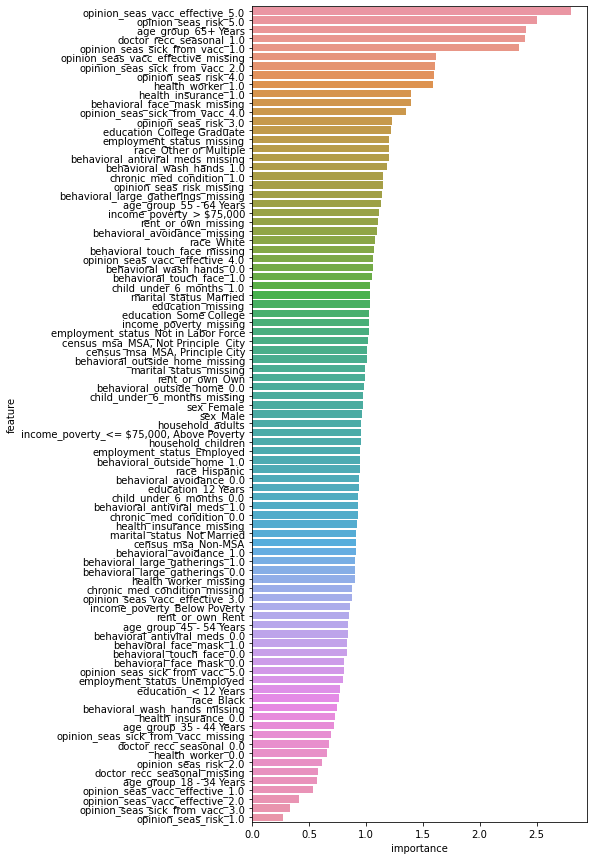

In [89]:
f, ax = plt.subplots(figsize=(6, 15))
sns.barplot(x="importance", y="feature", data=feature_importance,orient='h');

In [101]:
log_reg_l1 = LogisticRegression(random_state=42)

log_reg_l1.fit(X_new,y)

preds_l1 = log_reg_l1.predict(X_new)

/Users/Amelia/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [102]:
np.mean(cross_val_score(log_reg_l1,X_new,y,cv=5))

/Users/Amelia/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/Amelia/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

0.7785170213741642

In [104]:
# try using GridSearchCV to see if any paramters can be improved
params = ({'fit_intercept':[True,False],
           'C':[1,50,100,1000,10000,1e16]})

grid_search = GridSearchCV(log_reg,params,cv=5)

grid_search.fit(X_new,y)

GridSearchCV(cv=5,
             estimator=LogisticRegression(C=1e+16, fit_intercept=False,
                                          random_state=42, solver='liblinear'),
             param_grid={'C': [1, 50, 100, 1000, 10000, 1e+16],
                         'fit_intercept': [True, False]})

In [105]:
grid_search.best_params_

{'C': 1, 'fit_intercept': True}

In [109]:
np.mean(grid_search.cv_results_['mean_test_score'])

0.7784508766651624

In [111]:
grid_search.cv_results_

{'mean_fit_time': array([0.11151175, 0.11117067, 0.12690878, 0.11413221, 0.12396641,
        0.12118993, 0.11073861, 0.12267599, 0.11710844, 0.11237159,
        0.11222701, 0.11978645]),
 'std_fit_time': array([0.01797333, 0.01256193, 0.00627784, 0.01578762, 0.0132015 ,
        0.00732093, 0.01545401, 0.01920226, 0.01188437, 0.01627029,
        0.01140508, 0.0042331 ]),
 'mean_score_time': array([0.00218363, 0.00218143, 0.00199542, 0.00216932, 0.00202699,
        0.00229635, 0.00221205, 0.00215702, 0.0019484 , 0.00204315,
        0.00190539, 0.0019012 ]),
 'std_score_time': array([2.16306990e-04, 3.26253768e-04, 3.90891896e-05, 2.03055571e-04,
        4.39167799e-05, 5.41860207e-04, 3.48572594e-04, 3.01003863e-04,
        3.29712811e-05, 7.64278786e-05, 3.01489320e-05, 3.66389708e-06]),
 'param_C': masked_array(data=[1, 1, 50, 50, 100, 100, 1000, 1000, 10000, 10000,
                    1e+16, 1e+16],
              mask=[False, False, False, False, False, False, False, False,
          

In [112]:
# try using GridSearchCV to see if any paramters can be improved
params = ({'fit_intercept':[True,False],
           'C':[1,10,20,30,40]})

grid_search = GridSearchCV(log_reg,params,cv=5)

grid_search.fit(X_new,y)

GridSearchCV(cv=5,
             estimator=LogisticRegression(C=1e+16, fit_intercept=False,
                                          random_state=42, solver='liblinear'),
             param_grid={'C': [1, 10, 20, 30, 40],
                         'fit_intercept': [True, False]})

In [113]:
grid_search.best_params_

{'C': 1, 'fit_intercept': True}

## Model 2: Random Forest

With the logistic regression model as a baseline for accuracy, a slightly more complex model might be in order. A random forest model makes use of multiple decision trees, but accounts for the variance in the model by limiting the number of features used in each tree as well as its depth. Because random forests have far more tunable parameters than simple logistic regressions, multiple grid searches will have to be used to tune the parameters fully.

In [115]:
X = X_new.copy()

In [127]:
# create an initial random forest classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X,y)

RandomForestClassifier(random_state=42)

In [120]:
accuracy_score(y,preds_rf_test)

0.9986771486884874

In [126]:
np.mean(cross_val_score(rf_test,X,y,cv=5))

0.7719026290454861

The initial random forest, with default parameters, has roughly the same accuracy score as the logistic regression. To see if this can be improved upon, we must utilize grid searching of parameters to account for the fact that they are tuned simultaneously, which can affect results.

In [ ]:
# intialize parameter list for grid search #1
params_rf_1 = ({'n_estimators':[30,50,100],
                'criterion':['gini', 'entropy'],
                'max_depth':[None,2,5,10],
                'min_samples_split':[2,5,10],
                'min_samples_leaf':[2,5,10]})

rf_gs_1 = GridSearchCV(rf,params_rf_1,cv=3)
rf_gs_1.fit(X,y)